#### Project 2

Gabriel Castellanos, Beshkia Kvarnstrom

#### Loading Packages:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

## Reading in the Data

In [4]:
df = pd.read_csv("DataCoSupplyChainDataset.csv", encoding_errors="ignore")

## Data Cleaning and Preparation

As the dataset has lots of columns we will remove redundant/duplicate information to make working with it more simple.

Replacing spaces in column names makes it so that we can call them easier

In [5]:
old_new_dict = {old_name:old_name.replace(" ", "_") for old_name in df.columns}
df_prep = df.rename(columns=old_new_dict)
df_prep.rename(columns={"shipping_date_(DateOrders)": "shipping_date"}, inplace=True)

#### Handling NaN values

In [6]:
significant_nan_cols = []
for i in df_prep.columns:
    
    if sum(df_prep[i].isna())/len(df_prep) > 0.05:
        print(i)
        significant_nan_cols.append(i)

Order_Zipcode
Product_Description


As we can see, all of the Product Descriptions and most of the Zipcodes are NaN values and will therefore be excluded. Interestingly, although the zip code is missing more than 85%, we can still work with the "Customer City" columns since it does not have any missing values. Also, we will exclude "Product Image" from the data as we will not need it.

In [7]:
sum(df_prep["Customer_City"].isna())

0

In [8]:
df_no_nan = df_prep.drop(columns=list(significant_nan_cols) + ["Product_Image"])

#### Handling Attributes w/o Variance

Checking for variance in the data, columns that don't have any variance (i.e. only one value) can also be excluded. As we can see, Customer Email and Password have been redacted (for obvious reasons). Therefore, we can also exclude them from the Dataset.

In [9]:
def check_variance(data, log=False):
    
    no_variance_cols = []
    for i in data.dtypes.index:
        number_unique = len(data[i].value_counts())
        if number_unique == 1:
            print(i, "Unique Value: {}".format(data[i].value_counts().index[0]))
            no_variance_cols.append(i)
        
    if log:
        return no_variance_cols, {"No variability in attribute(s):": no_variance_cols}
    else:            
        return no_variance_cols

no_variance_cols, variance_log = check_variance(df_no_nan, log=True)

Customer_Email Unique Value: XXXXXXXXX
Customer_Password Unique Value: XXXXXXXXX
Product_Status Unique Value: 0


In [10]:
df_var = df_no_nan.drop(columns=no_variance_cols)

In [11]:
print("Columns removed: {}".format(len(df.columns) - len(df_var.columns)))

Columns removed: 6


In total we removed 6 columns without losing any information while making the dataset more lean and easier to work with

In [12]:
one_order_id = df_var.loc[df_var["Order_Id"] == 48880]

As we can see, almost all columns are the same except for things such as Benefits per order and category id as these are specific to the product. These columns will be aggregated later on.

#### Customer Information

For this, we will summarize all the neccessary information about a customer, we will also drop some columns as they would not make sense.

In [13]:
# df_prep.groupby(["Customer Id"]).agg()
len(df_var.loc[df_var.Order_Customer_Id == df_var.Customer_Id])/len(df_var)

1.0

### Removing Redundancies

At this point, we can see that even the Order Customer Id and Customer Id are the same. It would make sense to make a function that check for all columns wether the values match to 100% to remove redundancies. Otherwiese one could opt to consult the makers of the dataset for further info

In [14]:
from itertools import combinations

def check_redundancies(data):
    
    redundancy_list = []
    
    for i in list(combinations(data.columns, 2)):
        
        if all(data[i[0]] == data[i[1]]):
            redundancy_list.append(i)
            print("{} and {} are the same".format(*i))
    
    return redundancy_list
                
redundancies = check_redundancies(df_var)

Benefit_per_order and Order_Profit_Per_Order are the same
Sales_per_customer and Order_Item_Total are the same
Category_Id and Product_Category_Id are the same
Customer_Id and Order_Customer_Id are the same
Order_Item_Cardprod_Id and Product_Card_Id are the same
Order_Item_Product_Price and Product_Price are the same


Let's always remove the column witht the shortest name to make life even simpler

In [15]:
to_drop =[]
for i in redundancies:
    if len(i[0]) < len(i[1]):
        to_drop.append(i[1])
    else:
        to_drop.append(i[0])

In [16]:
df_clean = df_var.drop(columns=to_drop)

Because we will identify customers/departments by their CustomerId/DepartmentId there is no need for the Customer_Lname Customer_Fname and DepartmentId columns

In [17]:
df_clean.drop(columns=["Customer_Lname", "Customer_Fname", "Department_Name"], inplace=True)

In [18]:
df_clean["shipping_date"] = pd.to_datetime(df_clean["shipping_date"]) 

In [19]:
len(df_clean.columns) - len(df.columns)

-15

## Mapping Supply Chain as a Bipartite Graph.

We can also map the supply chain as a bipartite graph where one node set represents the department stores and the other one customers (Customer Regions to be more specific.)

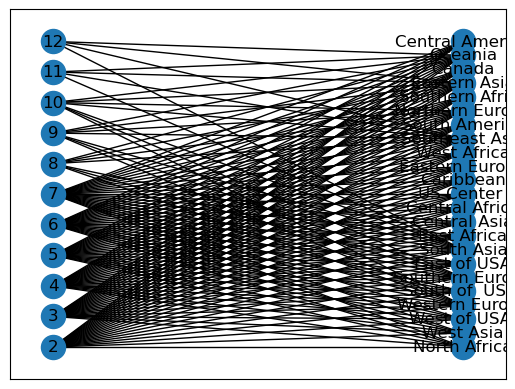

In [25]:
def show_bipartite(df, dep_id=None):
    g = nx.Graph()
    
    if dep_id:
        df = df.loc[df["Department_Id"].isin(dep_id)]
        
    departments = df.Department_Id.unique()

    for department in departments:
        g.add_node(department)
        
        dep_info = df.loc[df["Department_Id"] == department, ["Sales", "Order_Region"]]
        dep_sales = np.sum(dep_info).Sales
        dep_regions = dep_info.groupby(["Order_Region"]).agg("sum")
        
        g.add_edges_from([(department, i) for i in dep_regions.index])
        g.add_nodes_from(dep_regions.index)

    nx.draw_networkx(g, with_labels=True, pos=nx.bipartite_layout(g, departments))
    return g
    
    
g = show_bipartite(df_clean)

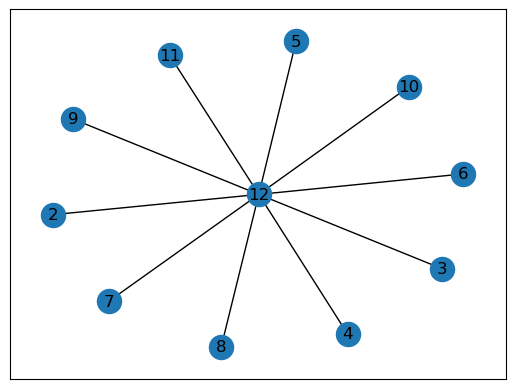

In [26]:
# 2 nodes will be connected if they have a common neighbor in the other node set.
projected = nx.bipartite.projected_graph(g, [12])
nx.draw_networkx(projected, with_labels=True)

Note that because we have selected all the years and even one sale made to the region counts as a connection, almost all departments have connections with almost all of the regions. We could of course adjust this by changing the timeframe or only considering departments as connected with regions once they reach a specific threshold (e.g. percentage of total sales).

In [37]:



largest_cc = max(nx.connected_components(g), key=len)

[len(c) for c in sorted(nx.connected_components(g), key=len, reverse=True)] 

nx.connected_components(g)

largest_cc ## Largest connected component within the graph

{10,
 11,
 12,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 'Canada',
 'Caribbean',
 'Central Africa',
 'Central America',
 'Central Asia',
 'East Africa',
 'East of USA',
 'Eastern Asia',
 'Eastern Europe',
 'North Africa',
 'Northern Europe',
 'Oceania',
 'South America',
 'South Asia',
 'South of  USA ',
 'Southeast Asia',
 'Southern Africa',
 'Southern Europe',
 'US Center ',
 'West Africa',
 'West Asia',
 'West of USA ',
 'Western Europe'}

## Analysis


The code in the preceding two cells show us a sorted list of the connected components within the graph, the sixe of each connected component, and, the connected component with the largest number of edges. This can be used to reduce the size of a network graph because the largest connected components are the most important nodes that can be used for analysis. The connected components also show us the importance of each component. In our case, we can see which department IDs are connected to which regions. 

#### References 

https://www.kaggle.com/code/laurinbrechter/data-cleaning-aggregation-and-bipartite-graph